In [2]:
#import numpy as np
import pandas as pd

In [3]:
# Dane ze stooq.pl
#stocks = 'https://raw.githubusercontent.com/Mr-SuSeL/NeuralNetworkPredictsDowJones/main/19880101_20191231.csv'
stocks = 'https://raw.githubusercontent.com/Mr-SuSeL/NeuralNetworkPredictsDowJones/main/dji.csv'
data_raw = pd.read_csv(stocks, index_col='Date')

In [12]:
data_raw

,Open,High,Low,Close,Volume
Date,,,,,
1930-02-03,268.40,271.50,264.80,266.50,428572.0
1930-02-04,266.50,270.00,264.40,268.50,364286.0
1930-02-05,268.90,274.00,268.90,272.10,491730.0
1930-02-06,272.10,273.60,267.00,268.60,418421.0
1930-02-07,268.60,271.60,265.40,267.80,382331.0
...,...,...,...,...,...
2024-02-01,38175.34,38522.50,38106.84,38519.84,338731681.0
2024-02-02,38448.10,38783.62,38336.57,38654.42,387138485.0
2024-02-05,38546.77,38633.88,38220.40,38380.12,325369705.0


In [6]:
def generate_features(df):
    """
    Generuje dane indeksu Dow Jones w opaeciu o dane historyczne oraz stopy zwrotu
    @param df: ramka danych z kolumnami: "Open", "Close", "High", "Low", "Volume", "Adjusted Close"
    @return: ramka danych z nowymi cechami na wyjściu
    """
    df_new = pd.DataFrame()
    # 6 cech oryginalnych
    df_new['open'] = df['Open']
    df_new['open_1'] = df['Open'].shift(1)
    df_new['close_1'] = df['Close'].shift(1)
    df_new['high_1'] = df['High'].shift(1)
    df_new['low_1'] = df['Low'].shift(1)
    df_new['volume_1'] = df['Volume'].shift(1)
    # 31 wygenerownaych cech
    # średnia cena
    df_new['avg_price_5'] = df['Close'].rolling(5).mean().shift(1)
    df_new['avg_price_30'] = df['Close'].rolling(21).mean().shift(1)
    df_new['avg_price_365'] = df['Close'].rolling(252).mean().shift(1)
    df_new['ratio_avg_price_5_30'] = df_new['avg_price_5'] / df_new['avg_price_30']
    df_new['ratio_avg_price_5_365'] = df_new['avg_price_5'] / df_new['avg_price_365']
    df_new['ratio_avg_price_30_365'] = df_new['avg_price_30'] / df_new['avg_price_365']
    # średni wolumen
    df_new['avg_volume_5'] = df['Volume'].rolling(5).mean().shift(1)
    df_new['avg_volume_30'] = df['Volume'].rolling(21).mean().shift(1)
    df_new['avg_volume_365'] = df['Volume'].rolling(252).mean().shift(1)
    df_new['ratio_avg_volume_5_30'] = df_new['avg_volume_5'] / df_new['avg_volume_30']
    df_new['ratio_avg_volume_5_365'] = df_new['avg_volume_5'] / df_new['avg_volume_365']
    df_new['ratio_avg_volume_30_365'] = df_new['avg_volume_30'] / df_new['avg_volume_365']
    # odchylenie standardowe cen
    df_new['std_price_5'] = df['Close'].rolling(5).std().shift(1)
    df_new['std_price_30'] = df['Close'].rolling(21).std().shift(1)
    df_new['std_price_365'] = df['Close'].rolling(252).std().shift(1)
    df_new['ratio_std_price_5_30'] = df_new['std_price_5'] / df_new['std_price_30']
    df_new['ratio_std_price_5_365'] = df_new['std_price_5'] / df_new['std_price_365']
    df_new['ratio_std_price_30_365'] = df_new['std_price_30'] / df_new['std_price_365']
    # odchylenie standardowe wolumenu
    df_new['std_volume_5'] = df['Volume'].rolling(5).std().shift(1)
    df_new['std_volume_30'] = df['Volume'].rolling(21).std().shift(1)
    df_new['std_volume_365'] = df['Volume'].rolling(252).std().shift(1)
    df_new['ratio_std_volume_5_30'] = df_new['std_volume_5'] / df_new['std_volume_30']
    df_new['ratio_std_volume_5_365'] = df_new['std_volume_5'] / df_new['std_volume_365']
    df_new['ratio_std_volume_30_365'] = df_new['std_volume_30'] / df_new['std_volume_365']
    # return
    df_new['return_1'] = ((df['Close'] - df['Close'].shift(1)) / df['Close'].shift(1)).shift(1)
    df_new['return_5'] = ((df['Close'] - df['Close'].shift(5)) / df['Close'].shift(5)).shift(1)
    df_new['return_30'] = ((df['Close'] - df['Close'].shift(21)) / df['Close'].shift(21)).shift(1)
    df_new['return_365'] = ((df['Close'] - df['Close'].shift(252)) / df['Close'].shift(252)).shift(1)
    df_new['moving_avg_5'] = df_new['return_1'].rolling(5).mean().shift(1)
    df_new['moving_avg_30'] = df_new['return_1'].rolling(21).mean().shift(1)
    df_new['moving_avg_365'] = df_new['return_1'].rolling(252).mean().shift(1)
    # the target
    df_new['close'] = df['Close']
    df_new = df_new.dropna(axis=0)
    return df_new

In [7]:

# wywołanie funkcji na zmienionych (preprocessing) danych
data = generate_features(data_raw)

In [8]:
# Zakres danych od 1930 roku (od wtedy był dostępny wolumen na stooq.pl)
# podział danych na dane treningowe i testowe
start_train = '1930-02-03'
end_train = '2023-02-07'

start_test = '2023-02-07'
end_test = '2024-02-07'

In [9]:
# podział danych na dane treningowe i testowe
data_train = data.loc[start_train:end_train]
X_train = data_train.drop('close', axis=1).values
y_train = data_train['close'].values


data_test = data.loc[start_test:end_test]
X_test = data_test.drop('close', axis=1).values
y_test = data_test['close'].values

In [10]:
# Skalowanie, standaryzacja danych treningowych i testowych
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled_train = scaler.fit_transform(X_train)
X_scaled_test = scaler.transform(X_test)

In [15]:
X_scaled_train
X_scaled_test

array([[ 3.75697442e+00,  3.77185030e+00,  3.77336088e+00, ...,
        -1.15251820e-01,  2.91002449e-01, -5.28341207e-01],
       [ 3.80423093e+00,  3.75822595e+00,  3.80794031e+00, ...,
         1.56673552e-01,  4.74552124e-01, -4.54036695e-01],
       [ 3.80067940e+00,  3.80549592e+00,  3.78090882e+00, ...,
         2.97608141e-02,  2.05904766e-01, -4.07574289e-01],
       ...,
       [ 4.37865290e+00,  4.36723694e+00,  4.39336180e+00, ...,
         4.50590142e-01,  3.12379015e-01,  3.38221705e-01],
       [ 4.35862822e+00,  4.38008153e+00,  4.35765909e+00, ...,
         5.28653492e-01,  5.33276625e-01,  3.56318142e-01],
       [ 4.38738791e+00,  4.36005115e+00,  4.37604280e+00, ...,
        -1.90782028e-03,  3.85950188e-01,  3.23588862e-01]])

In [16]:
# Do sekwencyjnej budowy modelu
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

In [26]:
# Importuje metryki by ocenić jakość treningu
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [49]:
# Uczenie sieci
# losowość w oparciu o 'magiczne' ziarno
tf.random.set_seed(42)

# Budujemy model
model = Sequential([
    Dense(units=32, activation='relu'),
    Dense(units=1)
])

# kompilujemy model
model.compile(loss='mean_squared_error',
              optimizer=tf.keras.optimizers.Adam(0.1))

# metrics='acc' - same zera
# metrics=[tf.keras.metrics.AUC()] - same zera
#model.fit(X_scaled_train, y_train, epochs=100, verbose=True)
history = model.fit(X_scaled_train, y_train, epochs=10, verbose=True)

Epoch 1/10
754/754 [==============================] - 2s 1ms/step - loss: 4975179.0000
Epoch 2/10
754/754 [==============================] - 1s 2ms/step - loss: 55559.7695
Epoch 3/10
754/754 [==============================] - 1s 1ms/step - loss: 30183.8301
Epoch 4/10
754/754 [==============================] - 1s 2ms/step - loss: 25872.2480
Epoch 5/10
754/754 [==============================] - 1s 1ms/step - loss: 24550.0957
Epoch 6/10
754/754 [==============================] - 1s 1ms/step - loss: 28525.9648
Epoch 7/10
754/754 [==============================] - 1s 1ms/step - loss: 25714.1172
Epoch 8/10
754/754 [==============================] - 1s 1ms/step - loss: 27131.0859
Epoch 9/10
754/754 [==============================] - 1s 1ms/step - loss: 29563.2988
Epoch 10/10
754/754 [==============================] - 1s 1ms/step - loss: 25151.2363


In [18]:
# wykonuje predykcję w oparciu o model na danych testowych
predictions = model.predict(X_scaled_test)[:, 0]

# metryki - 2 rodzaje błędów: wzgl. i bezwzgl. oraz determinanta
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
print(f'MSE: {mean_squared_error(y_test, predictions):.3f}')
print(f'MAE: {mean_absolute_error(y_test, predictions):.3f}')
print(f'R^2: {r2_score(y_test, predictions):.3f}')

8/8 [==============================] - 0s 1ms/step
MSE: 81274.855
MAE: 228.378
R^2: 0.969


In [19]:
# Testowanie sieci
model = Sequential([
    Dense(units=16, activation='relu'),
    Dense(units=1)
])

# Optymalizator Adam, czyli samodostosowujący szybkośc uczenia się dla SGD
model.compile(loss='mean_squared_error',
              optimizer=tf.keras.optimizers.Adam(0.21))
#model.summary()

#model.fit(X_scaled_train, y_train, epochs=1000, verbose=False)
model.fit(X_scaled_train, y_train, epochs=20, verbose=False)

predictions = model.predict(X_scaled_test)[:, 0]

8/8 [==============================] - 0s 1ms/step


In [56]:
import matplotlib.pyplot as plt

def make_loss_plot(history):
  #import seaborn as sns
  #sns.set()
  loss = history.history['loss']
  epochs = range(1, len(loss) + 1)
  plt.figure(figsize=(9, 4))
  plt.plot(epochs, loss, label='Strata treningowa', marker='o')
  plt.legend()
  plt.title('Strata trenowania')
  plt.xlabel('Epoki')
  plt.ylabel('Strata')
  plt.show()

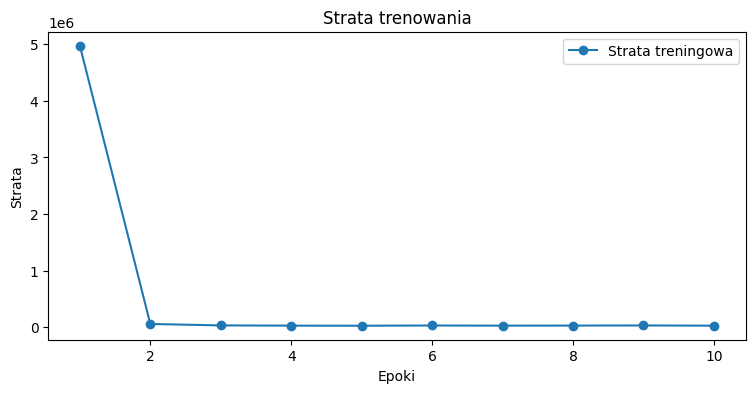

In [57]:
make_loss_plot(history)

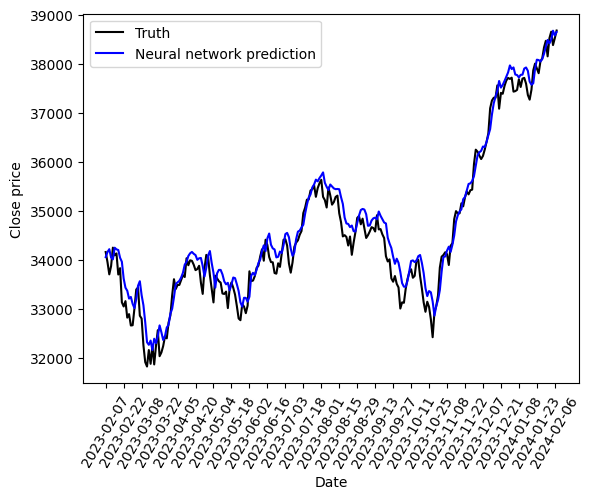

In [24]:
# wizualizacja porównania notowań oraz predykcji sieci neuronowej na danych testowych
#import matplotlib.pyplot as plt
plt.plot(data_test.index, y_test, c='k')
plt.plot(data_test.index, predictions, c='b')
plt.xticks(range(0, 252, 10), rotation=60)
plt.xlabel('Date')
plt.ylabel('Close price')
plt.legend(['Truth', 'Neural network prediction'])
plt.show()

Porównanie z inną metodą - SVR: regresja wektorów nośnych z 
jądrem liniowym i radialną funkcją bazową

In [31]:
'''
param_grid = [
    {'kernel':['linear'], 'C': [100, 300, 500],
     'epsilon': [0.00003, 0.0001]},
    {'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                'C': [10, 100, 1000], 'epsilon': [0.00003, 0.0001]}
]
'''
# w teście wyszło, że te najlepsze:
param_grid = [
    {'kernel': 'linear', 
     'C': 500,
     'epsilon': 0.0001}
    ]

In [20]:
# importuję funkcję regresyjnej maszyny wektorów nośnych
from sklearn.svm import SVR
svr = SVR()
#svr = SVR?

In [21]:
# szukanie najlepszego parametru zamuliło komputer na 70 minut i przekroczyło limity colaba
#from sklearn.model_selection import GridSearchCV
#grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='r2')
#grid_search.fit(X_scaled_train, y_train)

# create an SVR model with a linear kernel 
svr = SVR(kernel='linear', epsilon=0.05, C=10)
# best param: C=500, epsilon=0.0001
# but time is tragic

# trening modelu svr
svr.fit(X_scaled_train, y_train)

SVR(C=10, epsilon=0.05, kernel='linear')

In [22]:
# Testy SVRa
predictions_svr = svr.predict(X_scaled_test)

Metryki:

In [23]:
# Metryki modelu SVR
print(f'Błąd średniokwadratowy: {mean_squared_error(y_test, predictions_svr):.3f}')
print(f'MAE: {mean_absolute_error(y_test, predictions_svr):.3f}')
print(f'R^2: {r2_score(y_test, predictions_svr):.3f}')

Błąd średniokwadratowy: 67823.995
MAE: 210.149
R^2: 0.974


Porównanie obu metod

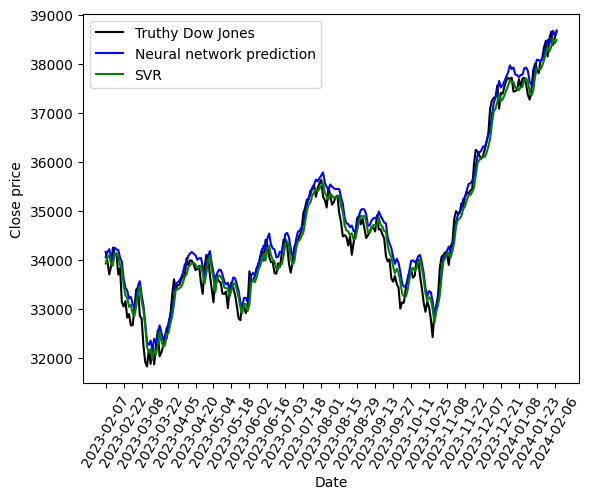

In [58]:
# wizualizacja porównania notowań oraz predykcji sieci neuronowej i SVR na danych testowych
plt.plot(data_test.index, y_test, c='k')
plt.plot(data_test.index, predictions, c='b')
plt.plot(data_test.index, predictions_svr, c='g')
plt.xticks(range(0, 252, 10), rotation=60)
plt.xlabel('Date')
plt.ylabel('Close price')
plt.legend(['Truthy Dow Jones', 'Neural network prediction', 'SVR'])
plt.show()

###### Dziękuje za uwagę
###### Pytanie: czy podkręcając technologię np. na RNN:LSTM oraz Tree:XGBoost da się stworzyć program, który będzie grać i zarabiać?